In [1]:
# import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from pyspark.sql import SparkSession
from itertools import combinations
from collections import defaultdict
import networkx as nx

In [2]:
# load Amazon Book Reviews dataset from Kaggle
os.environ['KAGGLE_USERNAME'] = "xxxx"
os.environ['KAGGLE_KEY'] = "xxxx"

!kaggle datasets download -d mohamedbakhet/amazon-books-reviews
!unzip -o amazon-books-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
 95% 1.01G/1.06G [00:07<00:01, 42.2MB/s]
100% 1.06G/1.06G [00:07<00:00, 143MB/s] 
Archive:  amazon-books-reviews.zip
  inflating: Books_rating.csv        
  inflating: books_data.csv          


In [3]:
spark = SparkSession.builder.appName("BookPageRank").getOrCreate()

# variable to control the percentage of the dataset to be used
sample_sizes = [0.1]
implementation_types = ["pyspark"]

# uncomment to run more subsample sizes and
# sample_sizes = [0.1, 0.3, 0.5]
# implementation_types = ["pyspark","python", "networkX"]

results = []

In [4]:
# load book ratings dataset and keep user id and book id columns
df = spark.read.csv("Books_rating.csv", header=True, inferSchema=True)
df = df.select("User_id", "Id", "Title").dropna()

book_id_to_title = df.select("Id", "Title").dropna().distinct().toPandas().set_index("Id")["Title"].to_dict()

In [5]:
def pagerank_vanilla_python(adj_list, max_iter=25, damping=0.85, tol=1e-6):
    # initialize ranks
    N = len(adj_list)
    ranks = {book: 1 / N for book in adj_list}

    # power iteration
    for _ in range(max_iter):
        new_ranks = defaultdict(float)
        for book, neighbors in adj_list.items():
            contribution = ranks[book] / len(neighbors)
            for neighbor in neighbors:
                new_ranks[neighbor] += contribution

        for book in adj_list:
            new_ranks[book] = (1 - damping) / N + damping * new_ranks[book]

        # early stopping if the difference is smaller than the threshold (using L1 norm)
        diff = sum(abs(new_ranks[book] - ranks[book]) for book in adj_list)
        if diff < tol:
            break

        ranks = new_ranks
    return ranks

In [6]:
def pagerank_pyspark(adj_list, max_iter=25, damping=0.85, tol=1e-6):
    # initialize ranks
    N = adj_list.count()
    ranks_rdd = adj_list.mapValues(lambda _ : 1/N)

    # power iteration
    for _ in range(max_iter):
        adj_ranks = adj_list.join(ranks_rdd) # (book, ([neighbors], current_rank))
        contribution = adj_ranks.flatMap(lambda x: [(neighbor, x[1][1]/len(x[1][0])) for neighbor in x[1][0]]) # (neighbor, contribution)
        new_ranks_rdd = contribution.reduceByKey(lambda x, y: x+y).mapValues(lambda x: (1 - damping) / N + damping * x) # (neighbor, new_rank)

        # early stopping if the difference is smaller than the threshold (using L1 norm)
        diff = ranks_rdd.join(new_ranks_rdd).mapValues(lambda x: abs(x[0] - x[1])).values().sum()
        if diff < tol:
            break

        ranks_rdd = new_ranks_rdd
    return dict(ranks_rdd.collect())

In [7]:
# iterate PageRank implementation on the specified sample sizes
for sample in sample_sizes:
    # get subsample and drop missing values
    sample_df = df.dropna(subset=["User_id", "Title"])
    sample_df = sample_df.sample(False, sample, seed=42)

    sample_pd = sample_df.toPandas()

    user_books = sample_pd.groupby('User_id')['Id'].apply(set)

    # create graph for pyspark impl (using RDD)
    sample_rdd = sample_df.rdd.map(lambda row: (row['User_id'], row['Id'])).aggregateByKey(set(), lambda acc, x: acc | {x}, lambda a, b: a | b)
    book_pairs_rdd = sample_rdd.flatMap(lambda row: combinations(row[1], 2))
    # create adjacency list
    book_edges_rdd = book_pairs_rdd.flatMap(lambda pair: [(pair[0], pair[1]), (pair[1], pair[0])]).distinct()
    books_adj_list_rdd = book_edges_rdd.groupByKey().mapValues(list)
    books_adj_list_rdd = books_adj_list_rdd.cache()

    # create graph edges for vanilla python impl
    book_edges = set()
    for books in user_books:
        book_edges.update(combinations(books, 2))
    # create adjacency list for the graph edges
    books_adj_list = defaultdict(set)
    for book1, book2 in book_edges:
        books_adj_list[book1].add(book2)
        books_adj_list[book2].add(book1)

    # create graph for networkX
    graph_nx = nx.Graph()
    graph_nx.add_edges_from(book_edges)

    # loop through three implementations
    for impl in implementation_types:
        try:
            start = time.time()
            if impl == "pyspark":
                result = pagerank_pyspark(books_adj_list_rdd)
            elif impl == "python":
                result = pagerank_vanilla_python(books_adj_list)
            elif impl == "networkX":
                result = nx.pagerank(graph_nx)

            # record elapsed time of the implementation used
            elapsed_time = time.time() - start
            results.append((impl, sample, elapsed_time))

            # print top 5 book results
            top_5 = sorted(result.items(), key=lambda x: x[1], reverse=True)[:5]
            print(f"\nTop 5 results for {impl} at sample size {sample*100}% of the full dataset:")
            for book_id, rank in top_5:
                title = book_id_to_title.get(book_id, "no title")
                print(f"Title: {title}, Rank: {rank:.6f}")
        except Exception as e:
            print(f"Error occurred for {impl} at sample size {sample*100}%: {e}")
            results.append((impl, sample, None))


Top 5 results for pyspark at sample size 10.0% of the full dataset:
Title: The Catcher in the Rye [Audiobook] [Cd] [Unabridged] (Audio CD), Rank: 0.000551
Title: The Catcher in the Rye, Rank: 0.000545
Title: Great Gatsby (Everyman), Rank: 0.000474
Title: The Hobbit, Rank: 0.000464
Title: Pride and Prejudice, Rank: 0.000456

Top 5 results for python at sample size 10.0% of the full dataset:
Title: The Catcher in the Rye [Audiobook] [Cd] [Unabridged] (Audio CD), Rank: 0.000551
Title: The Catcher in the Rye, Rank: 0.000545
Title: Great Gatsby (Everyman), Rank: 0.000474
Title: The Hobbit, Rank: 0.000464
Title: Pride and Prejudice, Rank: 0.000456

Top 5 results for networkX at sample size 10.0% of the full dataset:
Title: The Catcher in the Rye [Audiobook] [Cd] [Unabridged] (Audio CD), Rank: 0.000549
Title: The Catcher in the Rye, Rank: 0.000537
Title: Great Gatsby (Everyman), Rank: 0.000463
Title: The Hobbit, Rank: 0.000463
Title: To kill a mockingbird, Rank: 0.000453

Top 5 results for p

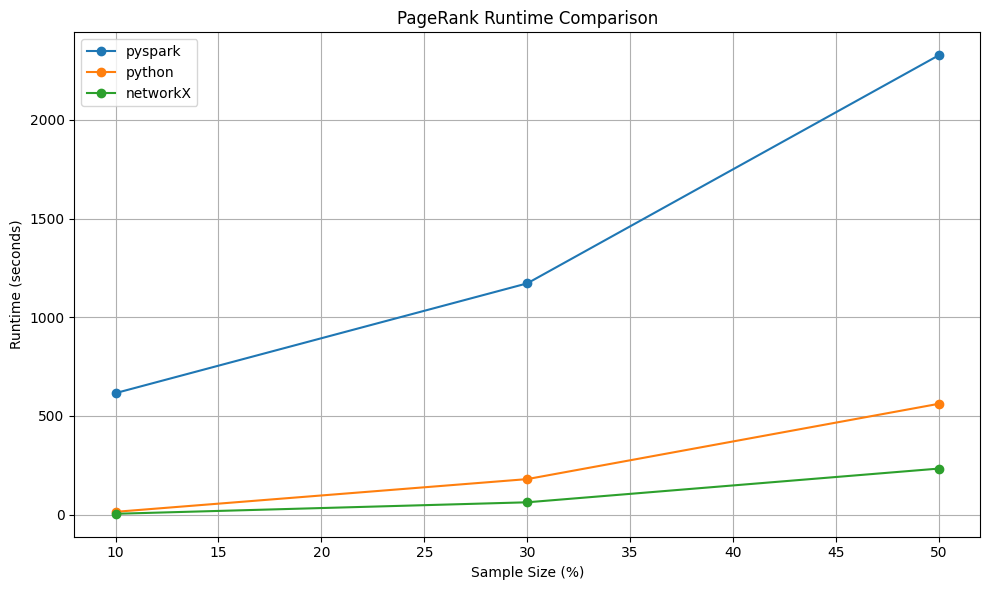

In [8]:
# store results for later reference
results_df = pd.DataFrame(results, columns=["implementation", "sample", "runtime"])
results_df.to_csv("pagerank_runtime_results.csv", index=False)

# plot graph to compare each implementation, sample size against runtime
plt.figure(figsize=(10, 6))
for impl in results_df["implementation"].unique():
    subset = results_df[results_df["implementation"] == impl]
    plt.plot(subset["sample"] * 100, subset["runtime"], marker="o", label=impl)

plt.title("PageRank Runtime Comparison")
plt.xlabel("Sample Size (%)")
plt.ylabel("Runtime (seconds)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()